In [4]:
#from pyscf import gto, scf, fci, lo
#import netket as nk; import netket.experimental as nkx
import numpy as np
import time
#import itertools
import qiskit
#from qiskit.quantum_info import Pauli, SparsePauliOp
from collections import defaultdict
#import tensorflow as tf
import sys
import os
import pandas as pd
#import itertools
from itertools import product
import matplotlib.pyplot as plt
#sys.path.append(os.path.dirname(os.getcwd()) + "/SAMPLER_LOCAL_IMPORT")
#from Sampling_Quantum import *
#from New_MCMC_Proposal import *
#sys.path.append(os.getcwd() + "/Code_download_Bell_2")
from MCMC_funs_Leyden import *

print(qiskit.version.get_version_info())
os.getcwd()

1.0.2


"c:\\Users\\vinit\\Downloads\\Research\\Quantum-Sampling\\Manas' Proposals"

In [ ]:
#Cluster_update_scheme (Swedson-Wang /Wolff type + Local Exchange)
#*****************************************************************


def all_configs(n):
    return [np.array(v) for v in product([-1, 1], repeat=n)]



def Sampling_MCMC_trajectories(problem_inst, Transition_matrix, sample_size=10000, 
                               burn=1000, method='Quantum', init_config=None):

    n = problem_inst.n
    beta = problem_inst.T
    prob_dist = np.zeros(2**n)

    #exact_dist = np.exp(-beta * Proposal_object.Energy_array)
    #exact_dist = exact_dist / np.sum(exact_dist)

    #err_hist = []
    key_list = []

    if init_config==None:
        s = np.random.choice([1,-1],size=n)
    else: s = init_config

    int_key = spinconf2int(s)
    #print(int_key)
    
    for k in range(burn):
        #s = Proposal_object.generate_MCMC_trajectories(Transition_matrix, s)
         int_key = generate_move(transition_mat=Transition_matrix, state=int_key)

    for k in range(sample_size):
        #s = Proposal_object.generate_MCMC_trajectories(Transition_matrix, s)
        int_key = generate_move(transition_mat=Transition_matrix, state=int_key)
        #key = spinconf2int(s)
        prob_dist[int_key] +=1
        key_list.append(int_key)

    
    return np.flip(prob_dist/np.sum(prob_dist)), key_list




#Continuous variable encoding (Hamiltonian Monte Carlo, Adaptive MCMC)
#*********************************************************************


def normalize_transition_matrix(T, eps=1e-12, verbose=False):
   
    T = np.copy(T)  
    T[T < 0] = 0.0  

    for j in range(T.shape[1]):
        col_sum = T[:, j].sum()
        if abs(col_sum) > eps:
            T[:, j] /= abs(col_sum)
        else:
            # Uniform fallback for ill-defined columns
            T[:, j] = 1.0 / T.shape[0]
            if verbose:
                print(f"Warning: column {j} had zero or near-zero sum. Reset to uniform.")

    # Validate after normalization
    if verbose:
        for j in range(T.shape[1]):
            if not np.isclose(T[:, j].sum(), 1.0, atol=1e-6):
                print(f"Column {j} sum = {T[:, j].sum()} (should be 1.0)")
            if np.any(T[:, j] < 0):
                print(f"Negative entries found in column {j}: {T[:, j][T[:, j] < 0]}")

    return T



def grad_U(x, J, h, alpha):
    #v = np.sign(np.tanh(alpha * x))
    t = np.tanh(alpha * x)
    sech_sq = 1.0 * (1 - t ** 2)
    return alpha * sech_sq * (h + 2 * J @ t)



def leapfrog_integrator(x, p, grad_U, epsilon, L, J, h, alpha):
    # Integrates hamilton's eqn of motion
    x_new = np.copy(x)
    p_new = np.copy(p) - 0.5 * epsilon * grad_U(x_new, J, h, alpha)
    for _ in range(L):
        x_new += epsilon * p_new
        if _ != L - 1:
            p_new -= epsilon * grad_U(x_new, J, h, alpha)
    p_new -= 0.5 * epsilon * grad_U(x_new, J, h, alpha)
    return x_new, p_new



def HMC_step(v, problem_inst, epsilon, L, alpha=2.0, num_p_samples=10):
    """HMC update for binary v using multiple momentum samples"""
    J_Q = problem_inst.J_quantum
    h_Q = problem_inst.h_quantum
    n = problem_inst.n
    beta = problem_inst.T
    
    x = np.arctanh(np.clip(v, -0.999, 0.999)) / alpha
    counts = {}

    for _ in range(num_p_samples):
        p = np.random.normal(size=n)

        v_old = np.sign(np.tanh(alpha * x))
        
        #U_x_init = config_energies[2**n - Proposal_object.get_spinconfig_to_int(v_old)-1]
        U_x_init = problem_inst.E_arr[::-1][spinconf2int(v_old)]
        H_init = 0.5 * np.sum(p**2) + U_x_init

        
        x_new, p_new = leapfrog_integrator(x, p, grad_U, epsilon, L, J_Q, h_Q, alpha)
        v_new = np.sign(np.tanh(alpha * x_new))

        U_x_final = problem_inst.E_arr[::-1][spinconf2int(v_new)]
        H_final = 0.5 * np.sum(p_new**2) + U_x_final

        accept_prob = min(1.0, np.exp(-(beta*H_final - beta*H_init)))

  
        if np.random.rand() < accept_prob:
            v_tuple = tuple(v_new.astype(int))
        else:
            v_tuple = tuple(v.astype(int))

        counts[v_tuple] = counts.get(v_tuple, 0) + 1

    return counts


def HMC_T_matrix(problem_inst, epsilon=0.1, L=10, alpha=3.0, num_samples=100, num_p_samples=10):

    from tqdm import tqdm
    J_Q = problem_inst.J_quantum
    h_Q = problem_inst.h_quantum
    n = problem_inst.n
    beta = problem_inst.T
    
    configs = all_configs(n)
    idx_map = {tuple(c): i for i, c in enumerate(configs)}
    T = np.zeros((2**n, 2**n))

    for v in tqdm(configs, desc="Building T matrix"):
        aggregate_counts = {}

        tmg = time.time()
        HMC_time_list = []
        print("Current state:", v, num_samples, num_p_samples)
        for _ in range(num_samples):
            tm = time.time()
            counts = HMC_step(np.array(v),problem_inst, epsilon, L, alpha, num_p_samples)
            HMC_time_list.append(time.time() - tm)

            for k, val in counts.items():
                aggregate_counts[k] = aggregate_counts.get(k, 0) + val

        plt.hist(HMC_time_list, bins=20)
        plt.show()
        
        print("Time for all HMC steps:", time.time() - tmg)
        break 
    
        i = idx_map[tuple(v)]
        total = sum(aggregate_counts.values())
        for v_prime, c in aggregate_counts.items():
            
            j = idx_map[v_prime]
            if j != i :
                T[j, i] = c / total
            #if j != i:
            #    T[i, j] = c / total

            #else:
        T[i,i] = 1-sum(T[:,i])    

    return T   

    T = normalize_transition_matrix(T, eps=1e-12, verbose=True)
    
    # T[T < 0] = 0
    # # T = T / T.sum(axis=0, keepdims=True)

    return T



Starting problem instance 8 of 1000 with n = 10


Building T matrix:   0%|          | 0/1024 [00:00<?, ?it/s]

Current state: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1] 300 30


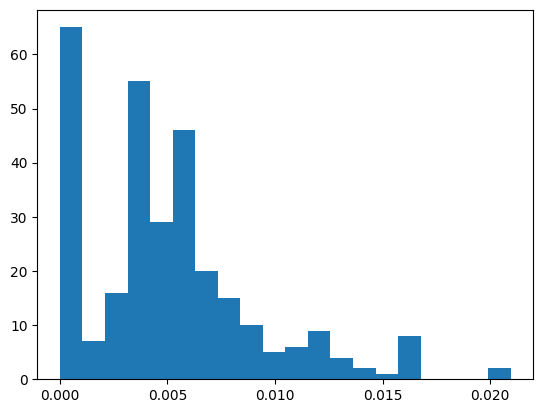

Building T matrix:   0%|          | 0/1024 [00:01<?, ?it/s]

Time for all HMC steps: 1.618232011795044


In [21]:
filepath = '/Users/vinit/Downloads/Research/Quantum-Sampling/Manas\' Proposals/'
filename_instances =  '/instances_new.pkl'
sample_size=1000

from tqdm import tqdm
instances = pd.read_pickle(filepath + filename_instances)
#tot_instances = np.max(instances['Instance Number'].values)
tot_instances = 1000
results = pd.DataFrame(columns = [
    'Instance Number',
    'Spins', 
    'Temperature', 
    'Connectivity',
    'Proposal',
    'Acceptance',
#    'Mismatched',
    'Gap',
    'Gap Lazy'
        ])
# T_logmesh = np.logspace(-3, 3, 50)
# T_round = np.sort( np.kron(np.array([1,5]), 10.**np.arange(-3,4)))
# T_lim = np.array([0, np.inf]) 
# T_arr = np.unique( np.concatenate((T_logmesh, T_round, T_lim))) 
# T_arr = [1]
delta_step = 0.2


for instance_num in range(1, tot_instances+1):
    instance_num = 8

    cond  = (instances['Instance Number']==instance_num)
    n            = instances[cond]['Spins'].values[0]
    connectivity = instances[cond]['Connectivity'].values[0]
    J            = instances[cond]['J'].values[0]
    h            = instances[cond]['h'].values[0]

    print('Starting problem instance', instance_num, 'of', tot_instances, 'with n =', n)

    problem_inst = ProblemInstance(J, h)

    T = 1
    prop_type = 'Continuous-HMC'
    accept_type = 'metropolis'


    problem_inst.T = T
    transition_mat = HMC_T_matrix(problem_inst, epsilon=0.2, L=10, alpha=3.0, num_samples=300, num_p_samples=30)

    break


    gap, _ = abs_spectral_gap(transition_mat)

    results_datum = {
        'Instance Number': instance_num,
        'Spins': n, 
        'Temperature': T, 
        'Connectivity': connectivity,
        'Proposal': prop_type,
        'Acceptance': accept_type,
        'Mismatched': False,
        'Gap': gap,
        "delta_time_step_Trotter": delta_step
    }


    print("Instance {}, T = {}, Proposal = {}, Acceptance = {}, Gap = {:.4f}".format(
        instance_num, T, prop_type, accept_type, gap))
    
    results = pd.concat([results,pd.DataFrame([results_datum])], ignore_index=True)

    
    # #Sampling
    # empirical_dist, key_list = Sampling_MCMC_trajectories(problem_inst, 
    #                                     Transition_matrix=transition_mat, sample_size=sample_size, burn=sample_size//10)

    # fig, ax = plt.subplots(1, figsize=(7,4))
    # if prop_type == 'quantum_time_mid_gamma_mid_Trotter':
    #     prop_type = 'quantum_circ'
    # ax.plot(empirical_dist, label=prop_type + ' n={}'.format(problem_inst.n))
    # exact_dist = np.exp(-problem_inst.T*problem_inst.E_arr[::-1])
    # exact_dist = exact_dist / np.sum(exact_dist)

    # ax.plot(exact_dist, marker='o', linestyle='dashed', label='exact,  n={}'.format(problem_inst.n))
    
    # ax.set_xlabel("Configurations(s)", fontsize=16)
    # ax.set_ylabel("P(s)", fontsize=16)
    # ax.legend(loc='best', fontsize=12)
    # ax.tick_params(axis='both', which='major', labelsize=12)
    # plt.savefig(os.getcwd() + "/Figures/{}_vs_configs_n_{}.png".format(prop_type, problem_inst.n), bbox_inches='tight')
    # plt.show()

#results.to_pickle('results_new_all_prop.pkl')

In [19]:
1.8/0.02

90.0